In this post I will demonstrate how to use the Beautiful Soup Python library to scrape data from a web page. Beautiful Soup builds a tree out of elements in HTML and XML files and provides an interface to access them. 



In [18]:
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

In [12]:
years = [2015, 2016]
urls = ['http://www.empirerunners.com/results/empireopen/eo{}.html'.format(str(year)[2:]) for year in years]
urls

['http://www.empirerunners.com/results/empireopen/eo15.html',
 'http://www.empirerunners.com/results/empireopen/eo16.html']

First I use the library ```urllib2``` to read in the website URL and then I pass the HTML code to ```BeautifulSoup```.

In [13]:
html = urllib2.urlopen(urls[0]).read()
soup = BeautifulSoup(html, 'html.parser')

Then I can call for specific tag objects to extract the relevant data. I search for the 'title' tag below.

In [48]:
print soup.find('title')

<title>Phil Widener Empire Open 2015</title>


However, what I'm most interested in is the table that contains the results. First I use "find_all" to look for all elements with the "table" tag and confirm that there is only one table on the website.

In [49]:
print len(soup.find_all('table'))

1


Then I go ahead and extract the html code corresponding to the table and print it, using the ```prettify``` method which gives a better visual representation of the tree structure. As you can see the the ```<td>``` tag always is nested within the ```<tr>``` tag. ```<tr>``` is used to identify each row within a table and ```<td>``` identifies each cell whtin each row. Knowing this structure allows us to parse apart the data elements.

In [50]:
table = soup.find('table')
print table.prettify()

<table border="0" cellpadding="0" cellspacing="0" class="racetable">
 <tr>
  <td class="h01" colspan="9">
   <h3>
    Women's Race
   </h3>
  </td>
 </tr>
 <tr>
  <td class="h11">
   Place
  </td>
  <td class="h12">
   Name
  </td>
  <td class="h12">
   Team
  </td>
  <td class="h11">
   Bib No
  </td>
  <td class="h11">
   Age
  </td>
  <td class="h11">
   Gender
  </td>
  <td class="h11">
   Age Group
  </td>
  <td class="h11">
   Total Time
  </td>
  <td class="h11">
   Pace
  </td>
 </tr>
 <tr>
  <td class="d01">
   1
  </td>
  <td class="d02">
   Alexandra Sciocchetti
  </td>
  <td class="d02">
   UNATTACHED
  </td>
  <td class="d01">
   189
  </td>
  <td class="d01">
   20
  </td>
  <td class="d01">
   F
  </td>
  <td class="d01">
   1/48 13-39
  </td>
  <td class="d01">
   20:20
  </td>
  <td class="d01">
   5:55/M
  </td>
 </tr>
 <tr>
  <td class="d01">
   2
  </td>
  <td class="d02">
   Tamma Carleton
  </td>
  <td class="d02">
   Strawberry Canyon TC
  </td>
  <td class="d01"

Using a nested list comprehension along with the BeautifulSoup search tags, I can extract the data from the table in one line of code. I find all of the table rows by searching for the ```<tr>``` tag with the command ```table.find_all('tr')```. I find the cell values for each cell within each row by searching for the ```<td>``` tag using ```row.find_all('td')```. I extract only the text identified by these tags and use the ```strip()``` method to get rid of white space. The result is a nested list of all of the table data elements.

In [59]:
cell_values = [[cell_value.text.strip() for cell_value in row.find_all('td')] for row in table.find_all('tr')]
cell_values[:5]

[[u"Women's Race"],
 [u'Place',
  u'Name',
  u'Team',
  u'Bib No',
  u'Age',
  u'Gender',
  u'Age Group',
  u'Total Time',
  u'Pace'],
 [u'1',
  u'Alexandra Sciocchetti',
  u'UNATTACHED',
  u'189',
  u'20',
  u'F',
  u'1/48 13-39',
  u'20:20',
  u'5:55/M'],
 [u'2',
  u'Tamma Carleton',
  u'Strawberry Canyon TC',
  u'114',
  u'27',
  u'F',
  u'2/48 13-39',
  u'20:23',
  u'5:56/M'],
 [u'3',
  u'Julia Sizek',
  u'Strawberry Canyon TC',
  u'191',
  u'24',
  u'F',
  u'3/48 13-39',
  u'20:26',
  u'5:57/M']]

![title](website_screenshot.png)

In [90]:
df=pd.DataFrame()
for year, url in zip(years, urls):
    html = urllib2.urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    
    data=[]
    table=soup.find('table')
    rows=table.find_all('tr')
    values=[[val.text.strip() for val in row.find_all('td')] for row in rows]
    header=[row for row in values if len(row)==9][0]

    data_clean=[]
    for value in values:
        if value<>header and len(value)==9:
            data_clean.append(value)

    d=pd.DataFrame(data_clean, columns=header)
    d['Year']=year
    df=df.append(d)

In [109]:
def convert_to_datetime(time_string):
    t=datetime.strptime(time_string, "%M:%S")
    delta = timedelta(minutes=t.minute, seconds=t.second)
    return delta

def convert_to_minutes(time_string):
    t=datetime.strptime(time_string, "%M:%S")
    delta = timedelta(minutes=t.minute, seconds=t.second)
    return delta.seconds/float(60)



In [110]:
df['Time']= df['Total Time'].apply(convert_to_datetime)
df['Minutes'] = df['Total Time'].apply(convert_to_minutes)
num_cols = ['Place' ,'Age', 'Bib No']
df[num_cols] = df[num_cols].astype(int)
df = df.sort_values(by = 'Total Time').reset_index(drop=True)
print df[:5]

   Place              Name                    Team  Bib No  Age Gender  \
0      1      Isaac Chavez     Aggies Running Club     414   24      M   
1      2  Malcolm Richards  West Valley Track Club     306   32      M   
2      1    Trevor Halsted              UNATTACHED     701   23      M   
3      2  Malcolm Richards  West Valley Track Club     623   33      M   
4      3  Alfonso Cisneros     Aggies Running Club     413   23      M   

    Age Group Total Time    Pace  Year     Time    Minutes  
0  1/52 16-99      16:51  4:54/M  2015 00:16:51  16.850000  
1  2/52 16-99      16:56  4:56/M  2015 00:16:56  16.933333  
2     1 16-99      16:56  4:56/M  2016 00:16:56  16.933333  
3     2 16-99      17:05  4:59/M  2016 00:17:05  17.083333  
4  3/52 16-99      17:07  4:59/M  2015 00:17:07  17.116667  


In [111]:
df.groupby(['Team','Gender'])['Time'].agg(lambda x:x.mean()).unstack()['F'].sort_values()[:5]

Team
SRA Elite                         00:20:43
Aggies Running Club               00:21:08
Forward Motion Race Club          00:21:32
Strawberry Canyon TC       00:21:39.800000
Wolfpack RC                00:22:51.666666
Name: F, dtype: timedelta64[ns]

In [112]:
df.groupby(['Team','Gender'])['Time'].agg(lambda x:x.mean()).unstack()['M'].sort_values()[:5]

Team
Aggies Running Club      00:18:42.888888
West Valley Track Club   00:19:06.583333
Strawberry Canyon TC     00:19:41.700000
River City Rebels        00:19:46.666666
Excelsior Running Club   00:20:37.400000
Name: M, dtype: timedelta64[ns]

In [82]:
df.groupby('Year')['Time'].agg(lambda x:x.mean())

Year
2015   00:24:28.269896
2016   00:24:39.542635
Name: Time, dtype: timedelta64[ns]

In [151]:
time_compare = df.pivot(index='Name', columns='Year', values='Time').dropna()
abs_time_diff=(time_compare[2015]-time_compare[2016]).abs()
print time_compare.reindex(abs_time_diff.sort_values().index)[:5]

Year                 2015     2016
Name                              
Laurie Smith     00:25:43 00:25:42
Nicholas Spector 00:17:32 00:17:33
Tim Wallen       00:20:23 00:20:22
Carlos Castelo   00:22:11 00:22:12
Carla Kehoe      00:23:24 00:23:20


In [152]:
print time_compare.reindex(abs_time_diff.sort_values(ascending=False).index)[:5]

Year               2015     2016
Name                            
Larry Morris   00:45:10 00:32:48
Steve Cryer    00:25:21 00:28:00
William Rostel 00:25:56 00:27:57
David White    00:21:40 00:19:40
Paden Collard  00:21:44 00:19:47


In [161]:
time_compare[:10]

Year,2015,2016
Name,,
Adele Ho,00:30:27,00:32:09
Andrea Guzman,00:24:48,00:25:12
Andrew Gaidus,00:18:45,00:18:59
Andrew Taylor,00:24:08,00:24:22
Angela Broad,00:22:25,00:23:18
Angie Longworth,00:24:53,00:25:28
Arnold Utterback,00:25:56,00:26:32
Bradley Zanetti,00:24:17,00:25:47
Brandon Crowell,00:21:27,00:20:52


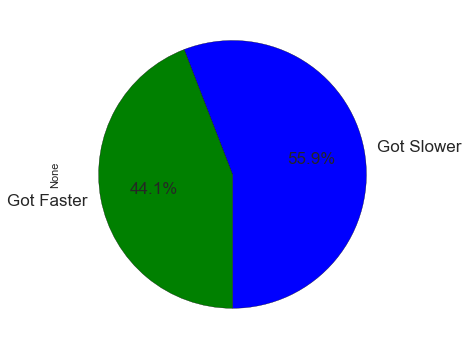

In [184]:
got_slower = ((time_compare[2015]-time_compare[2016])<timedelta(0)).map({True:'Got Slower', False: 'Got Faster'})

fig = plt.figure(figsize=(6,6), dpi=200)
ax = plt.subplot(111)

got_slower.value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=270, fontsize=17)
#got_slower.value_counts().plot.pie(equal_axis=True)

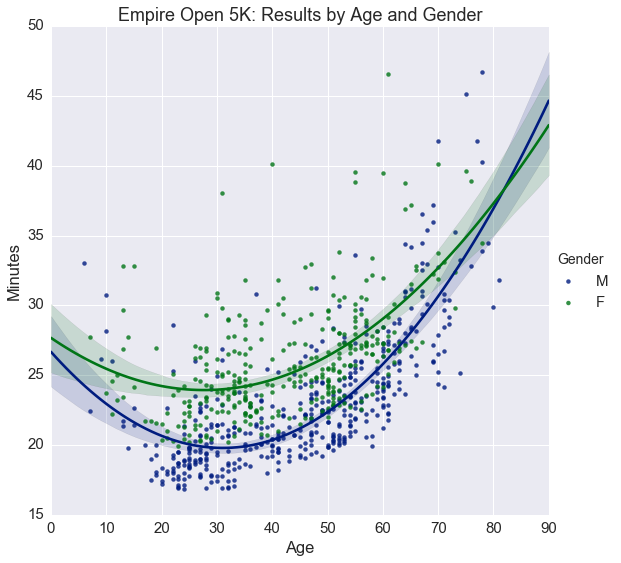

In [57]:
sns.lmplot('Age', 'Minutes', data=df, hue='Gender', order=2, size=8, palette='dark')
t=plt.title('Empire Open 5K: Results by Age and Gender', size=18)


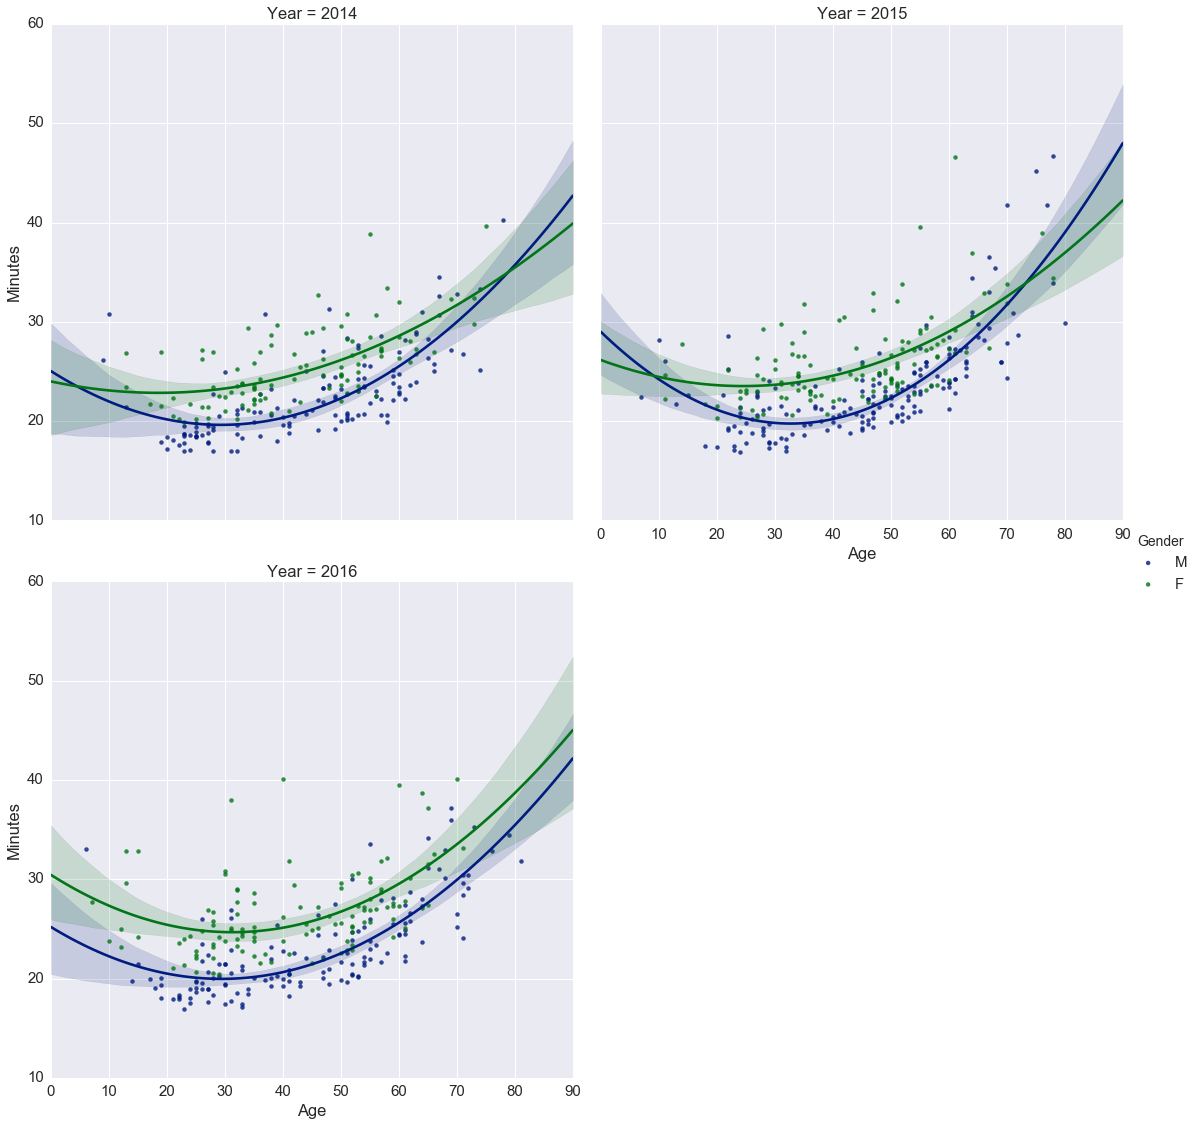

In [70]:
sns.lmplot('Age', 'Minutes', data=df, hue='Gender', order=2, size=8, palette='dark', col='Year', col_wrap=2)

Beautiful Soup is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree. It commonly saves programmers hours or days of work.

These instructions illustrate all major features of Beautiful Soup 4, with examples. I show you what the library is good for, how it works, how to use it, how to make it do what you want, and what to do when it violates your expectations.

The examples in this documentation should work the same way in Python 2.7 and Python 3.2.

You might be looking for the documentation for Beautiful Soup 3. If so, you should know that Beautiful Soup 3 is no longer being developed, and that Beautiful Soup 4 is recommended for all new projects. If you want to learn about the differences between Beautiful Soup 3 and Beautiful Soup 4, see Porting code to BS4.

This documentation has been translated into other languages by Beautiful Soup users:



http://savvastjortjoglou.com/nba-draft-part01-scraping.html